## FineTuning 

In [4]:
import time

def measure_single_token_generation_time(target_model, tokenizer, device, prompt="Test prompt"):
    """
    Measures the time taken by the target model to generate a single token.

    Args:
        target_model (AutoModelForCausalLM): The target language model.
        tokenizer (AutoTokenizer): The tokenizer associated with the model.
        device (str): The device to run the model on ('cuda' or 'cpu').
        prompt (str): The prompt to start generation from. Defaults to "Test prompt".

    Returns:
        float: The average time taken for single token generation (in seconds).
    """
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones_like(input_ids)

    # Warm-up to ensure fair timing
    with torch.no_grad():
        _ = target_model(input_ids, attention_mask=attention_mask)

    # Measure time for single token generation
    num_runs = 100  # Number of repetitions for averaging
    total_time = 0

    for _ in range(num_runs):
        start_time = time.time()
        with torch.no_grad():
            outputs = target_model(input_ids, attention_mask=attention_mask, return_dict=True)
            logits = outputs.logits[:, -1, :]  # Logits for the last token
            _ = torch.argmax(logits, dim=-1)  # Simulate single token prediction
        end_time = time.time()
        total_time += (end_time - start_time)

    avg_time_per_token = total_time / num_runs
    print(f"Average time per token (single token generation): {avg_time_per_token:.6f} seconds")
    return avg_time_per_token

# Example usage
# Instantiate SpeculativeDecoder and measure single token time
decoder = SpeculativeDecoder(target_model_name="EleutherAI/gpt-neo-1.3B", draft_model_name="distilgpt2")
single_token_time = measure_single_token_generation_time(
    decoder.Mp, decoder.tokenizer, decoder.device
)


config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Average time per token (single token generation): 0.035139 seconds


In [2]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import load_dataset
import argparse

# Import required libraries
import os
import argparse
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling, set_seed
from datasets import load_dataset
from torch.utils.data import Dataset

# Define the dataset class

# Set random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

os.environ["WANDB_DISABLED"] = "true"

In [2]:
class CNNDailyMailGPT2Dataset(Dataset):
    def __init__(self, data, tokenizer, max_length, prompt_prefix="summarize: "):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.prompt_prefix = prompt_prefix
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        article = self.data[idx]['article']
        highlights = self.data[idx]['highlights']
        input_text = self.prompt_prefix + article
        target_text = highlights

        input_tokens = self.tokenizer.encode_plus(
            input_text, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt'
        )
        target_tokens = self.tokenizer.encode_plus(
            target_text, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt'
        )

        input_ids = input_tokens['input_ids'].squeeze()
        attention_mask = input_tokens['attention_mask'].squeeze()
        labels = target_tokens['input_ids'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

In [2]:
model_name = 'distilgpt2'  # Modify to 'gpt2', 'gpt2-large', etc. as needed

batch_size = 4
max_length = 1024
epochs = 1
seed = 42
# Set up argument parsing for Kaggle notebook
output_dir = f'/kaggle/working/{model_name}_epochs{epochs}_batch{batch_size}_max_len{max_length}'  # Kaggle's working directory for output
os.makedirs(output_dir, exist_ok=True)


# Set random seed
set_seed(seed)

# Load dataset from Hugging Face
dataset = load_dataset('cnn_dailymail', '3.0.0')



train_data = dataset['train']
val_data = dataset['validation']

# Limit train_data to the first 10,000 samples
# train_data = train_data.select(range(50000))
val_data = val_data.select(range(3000))
# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Create datasets
train_dataset = CNNDailyMailGPT2Dataset(train_data, tokenizer, max_length)

val_dataset = CNNDailyMailGPT2Dataset(val_data, tokenizer, max_length)

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


NameError: name 'CNNDailyMailGPT2Dataset' is not defined

In [5]:
len(val_dataset)

3000

In [6]:
# Initialize model
model = GPT2LMHeadModel.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# Define data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [7]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Train model
trainer.train()

# Save the model and tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
import shutil
import os
from IPython.display import FileLink

# Define the output directory you want to zip
output_dir = '/kaggle/working/model_output'  # Path to your model output folder

# Zip the output directory
shutil.make_archive(output_dir, 'zip', output_dir)

# Now you can generate a clickable link to download the file
download_link = FileLink(f'{output_dir}.zip')

# Display the link to download the file
download_link

## SpeculativeDecoder

In [3]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import time
from tqdm import tqdm

In [13]:
class SpeculativeDecoder:
    """
    A class implementing speculative decoding for language models.

    This class uses a larger target model and a smaller draft model to perform
    speculative decoding, potentially speeding up text generation.

    Attributes:
        device (str): The device to run the models on ('cuda' or 'cpu').
        target_model (AutoModelForCausalLM): The larger, more accurate language model.
        draft_model (AutoModelForCausalLM): The smaller, faster language model for draft predictions.
        tokenizer (AutoTokenizer): The tokenizer for both models.
    """


    def __init__(self, target_model_name, draft_model_name, device='cuda' if torch.cuda.is_available() else 'cpu'):
        """
        Initialize the SpeculativeDecoder with target and draft models.

        Args:
            target_model_name (str): The name or path of the target (larger) model.
            draft_model_name (str): The name or path of the draft (smaller) model.
            device (str): The device to run the models on. Defaults to 'cuda' if available, else 'cpu'.
        """

        self.device = device
        self.Mp = AutoModelForCausalLM.from_pretrained(target_model_name).to(self.device)
        self.Mq = AutoModelForCausalLM.from_pretrained(draft_model_name).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(target_model_name)
        self.no_accepted_tokens = 0
        self.alpha = 0
        self.total_time_taken = 0

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        self.Mp.eval()
        self.Mq.eval()

    @staticmethod
    def sample(logits, temperature, top_k, top_p):

        """
        Adjust logits for sampling based on temperature, top-k, and top-p parameters.

        Args:
            logits (torch.Tensor): The input logits.
            temperature (float): The temperature for sampling.
            top_k (int): The number of top tokens to consider for top-k sampling.
            top_p (float): The cumulative probability threshold for top-p sampling.

        Returns:
            torch.Tensor: The adjusted probability distribution.
        """

        if temperature <= 1e-6:
            return F.one_hot(logits.argmax(dim=-1), num_classes=logits.size(-1)).float()

        logits = logits / temperature

        if top_k > 0:
            top_k = min(top_k, logits.size(-1))
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            logits[indices_to_remove] = float('-inf')

        if top_p < 1.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0
            indices_to_remove = sorted_indices_to_remove.scatter(dim=-1, index=sorted_indices, src=sorted_indices_to_remove)
            logits[indices_to_remove] = float('-inf')

        return F.softmax(logits, dim=-1)

    def generate(self, prompt, temperature=1.0, top_k=0, top_p=1.0, gamma=8, max_new_tokens=50):
        """
        Generate text using speculative decoding.

        Args:
            prompt (str): The input prompt to start generation from.
            temperature (float): The temperature for sampling. Defaults to 1.0.
            top_k (int): The number of top tokens to consider for top-k sampling. Defaults to 0 (disabled).
            top_p (float): The cumulative probability threshold for top-p sampling. Defaults to 1.0 (disabled).
            gamma (int): The number of tokens to generate speculatively in each iteration. Defaults to 5.
            max_new_tokens (int): The maximum number of new tokens to generate. Defaults to 100.

        Returns:
            str: The generated text.
        """
        stime = time.time()
        input_ids = self.tokenizer.encode(prompt, return_tensors="pt").to(self.device)
        attention_mask = torch.ones_like(input_ids)

        self.no_accepted_tokens = 0
        betas = []
        all_gammas = []

        for _ in range(0, max_new_tokens, gamma + 1):
            # Generate draft outputs
            all_gammas.append(gamma)
            start_time = time.time()

            with torch.no_grad():
                draft_outputs = self.Mq.generate(
                    input_ids,
                    attention_mask=attention_mask,
                    max_new_tokens=gamma,
                    do_sample=True,
                    temperature=temperature,
                    top_k=top_k,
                    top_p=top_p,
                    return_dict_in_generate=True,
                    output_scores=True,
                    pad_token_id=self.tokenizer.pad_token_id,
                )

            end_time = time.time()

            draft_tokens = draft_outputs.sequences[:, input_ids.size(1):] #torch.Size([1, 5])
            draft_probs = torch.stack(draft_outputs.scores).softmax(-1) #torch.Size([5, 1, 50257]) for GPT2
            #####################
            #Debugging
            # Print draft model tokens and decoded words
#             print(f"Draft Model: {(end_time-start_time):.3f}s", end = " ")
#             for i, token in enumerate(draft_tokens[0]):
#                 word = self.tokenizer.decode(token.item(), skip_special_tokens=True)
#                 print(f"{word}", end = " ")
            #####################

            # Target model single forward pass
            start_time = time.time()
            with torch.no_grad():
                target_outputs = self.Mp(
                    torch.cat([input_ids, draft_tokens], dim=1),
                    attention_mask=torch.cat([attention_mask, torch.ones_like(draft_tokens)], dim=1),
                    return_dict=True,
                )

            end_time = time.time()
#             print(f"\n one run of target model: {end_time-start_time:.3f} s")

            target_logits = target_outputs.logits[:, input_ids.size(1)-1:-1]
            target_probs = self.sample(target_logits, temperature, top_k, top_p)

            # Speculative sampling
            accepted_tokens = []
            for i in range(min(gamma, draft_tokens.size(1))):
                draft_token = draft_tokens[:, i]
                draft_prob = draft_probs[i].gather(-1, draft_token.unsqueeze(-1)).squeeze(-1)
                target_prob = target_probs[:, i].gather(-1, draft_token.unsqueeze(-1)).squeeze(-1)

                accept_prob = torch.min(torch.ones_like(target_prob), target_prob / draft_prob)
                if torch.rand(1, device=self.device) < accept_prob:
                    accepted_tokens.append(draft_token)
                else:
                    break
                # if draft_prob <= target_prob:
                #     # Accept deterministically if draft prob <= target_prob
                #     accepted_tokens.append(draft_token)
                # else:
                #     # Probabilistic rejection if draft prob > target_prob
                #     rejection_prob = 1 - target_prob / draft_prob
                #     if torch.rand(1, device=self.device) < rejection_prob:
                #         break
            # Print accepted tokens
            self.no_accepted_tokens += len(accepted_tokens) + 1
            betas.append(len(accepted_tokens) / gamma)

            #####################
            #Debugging
#             print("\nAccepted:", end = " ")
#             for token in accepted_tokens:
#                 word = self.tokenizer.decode(token.item(), skip_special_tokens=True)
#                 print(f"{word}", end = " ")
            #####################

            num_accepted = len(accepted_tokens)
            acceptance_rate = num_accepted / gamma

            if acceptance_rate > 0.8 and gamma < 10:
                gamma += 1
            elif acceptance_rate < 0.2 and gamma > 2:
                gamma -= 1



            if num_accepted < draft_probs.size(1):
                adjusted_probs = torch.clamp(target_probs[:, num_accepted] - draft_probs[num_accepted], min=0)
                adjusted_probs /= adjusted_probs.sum(dim=-1, keepdim=True)
                next_token = torch.multinomial(adjusted_probs, num_samples=1)
            else:
                next_token = torch.multinomial(target_probs[:, -1], num_samples=1)

            #####################
            #Debugging
#             print(f"\nTarget Model:", end = " ")
#             print(f" {self.tokenizer.decode(next_token.item(), skip_special_tokens=True)}\n")
#             print("-------------------------------")
            ###################

            accepted_tokens.append(next_token)
            new_tokens = torch.cat([token.view(1, 1) for token in accepted_tokens], dim=1)

            input_ids = torch.cat([input_ids, new_tokens], dim=1)
            attention_mask = torch.cat([attention_mask, torch.ones_like(new_tokens)], dim=1) #update for next generation

            if input_ids.size(1) - len(self.tokenizer.encode(prompt)) >= max_new_tokens:
                break
#         print(f"\ntotal time taken: {time.time() -stime:.2f} s")
#         print(f"no of tokens produced {self.no_accepted_tokens}")

#         Here run Mp for producing self.no_accepted_tokens and note time
#         total_target_run_time = 0
#         for token in range(self.no_accepted_tokens):
#             start_time = time.time()
#             _ = self.Mp(input_ids)
#             end_time = time.time()
#             total_target_run_time += (end_time - start_time)

        self.alpha = sum(betas) / len(betas)

#         print(f"Total time taken for target model: {total_target_run_time} s")
#         print(f"α = success probability = E(β) = {sum(betas) / len(betas)}")

        # here run Mp for producing no_accepted_tokens and note time
        self.total_time_taken = time.time() - stime;

        return self.tokenizer.decode(input_ids[0], skip_special_tokens=True), all_gammas

    def target_generate_greedy(self, prompt, max_new_tokens=50):
        """
        Generate text using standard greedy decoding with the target model.

        Args:
            prompt (str): The input prompt to start generation from.
            max_new_tokens (int): The maximum number of new tokens to generate. Defaults to 50.

        Returns:
            str: The generated text.
        """
        model_inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        greedy_output = self.target_model.generate(**model_inputs, max_new_tokens=max_new_tokens)
        return self.tokenizer.decode(greedy_output[0])

    def draft_generate_greedy(self, prompt, max_new_tokens=50):
        """
        Generate text using standard greedy decoding with the draft model.

        Args:
            prompt (str): The input prompt to start generation from.
            max_new_tokens (int): The maximum number of new tokens to generate. Defaults to 50

        Returns:
            str: The generated text.
        """

        model_inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        greedy_output = self.draft_model.generate(**model_inputs, max_new_tokens=max_new_tokens)
        return self.tokenizer.decode(greedy_output[0])

| Model        | Parameters |
|--------------|----------------|
| gpt2-large   | 812 M           |
| gpt2-medium  | 380 M           |
| gpt2         | 137 M           |
| distilgpt2   | 88.2 M          |


In [14]:
model = SpeculativeDecoder(target_model_name='gpt2-large',
                                  draft_model_name='distilgpt2',
                                  device='cuda' if torch.cuda.is_available() else 'cpu')

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [15]:
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d  # For smoothing

def evaluate_speculative_decoding(dataset, spec_decoder, max_new_tokens=100, temperature=1.0, top_k=0, top_p=1.0, gamma=3, output_file="evaluation_results.txt"):
    total_time = 0
    total_target_model_time = 0
    total_tokens_produced = 0
    alphas = []

    # Open file to write outputs
    with open(output_file, "w") as f:
        # Loop through each sample in the dataset
        all_gamma_values = []
        for i, sample in enumerate(tqdm(dataset, desc="Evaluating Speculative Decoding")):
            prompt = sample['input_text']  # Modify prompt as needed

            # Perform speculative decoding and measure time and alpha
            start_time = time.time()
            
            generated_text, all_gammas = spec_decoder.generate(prompt, temperature=temperature, top_k=top_k, top_p=top_p, gamma=gamma, max_new_tokens=max_new_tokens)
            # f.write(f"Generated Text for Sample {i}:\n{generated_text}\n\n")
            decoding_time = time.time() - start_time

            # Collect timing metrics and alpha (success probability)
            total_time += decoding_time / spec_decoder.no_accepted_tokens
            total_tokens_produced += spec_decoder.no_accepted_tokens  # Assuming no_accepted_tokens is updated in spec_decoder
            alphas.append(spec_decoder.alpha)  # Assuming `alpha` is updated in `SpeculativeDecoder` after each generation
            all_gamma_values.extend(all_gammas)
#         avg_alpha = np.mean(alphas)
    
    temp = total_time / len(dataset)
    avg_alpha = np.mean(alphas)
    print("avg time taken by speculative decoding: ", temp)
#     print(f"\nEvaluation Results on Test Dataset:")
#     print(f"Average time per sample: {avg_time_per_sample:.2f} seconds")
    print(f"Average alpha (acceptance probability): {avg_alpha:.2f}")
#     print(f"Average time per token: {total_time / total_tokens_produced:.4f} seconds")
    

    # Smoothing gamma values for a cleaner plot
    smoothed_gamma_values = gaussian_filter1d(all_gamma_values, sigma=2)  # Adjust sigma for more/less smoothing

    # Plot gamma values
    plt.figure(figsize=(12, 6))
    plt.plot(smoothed_gamma_values, label="Smoothed Gamma Value", color='blue', linewidth=2)
    plt.scatter(range(len(all_gamma_values)), all_gamma_values, s=10, color='red', alpha=0.6, label="Original Gamma Values")
    plt.axhline(np.mean(all_gamma_values), color='green', linestyle='--', linewidth=1, label="Mean Gamma Value")
    plt.grid(alpha=0.3)
    plt.xlabel("Generation Step", fontsize=12)
    plt.ylabel("Gamma", fontsize=12)
    plt.title("Change in Gamma Value Over Generation Steps", fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    return {
#         "avg_time_per_sample": avg_time_per_sample,
#         "avg_tokens_per_sample": avg_tokens_per_sample,
        "avg_alpha": avg_alpha,
    }

In [16]:
# test_dataset[1]

Evaluating Speculative Decoding: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


avg time taken by speculative decoding:  0.028881561414585543
Average alpha (acceptance probability): 0.37


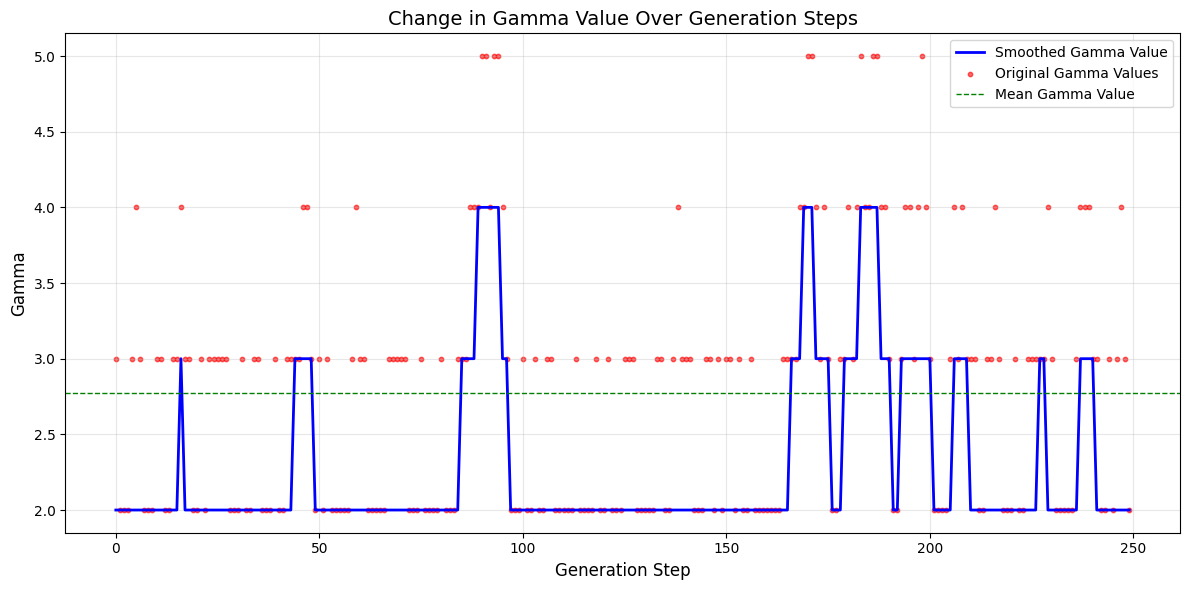

In [17]:
# Run evaluation
results = evaluate_speculative_decoding(test_dataset, model)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d  # For smoothing

def evaluate_speculative_decoding(dataset, spec_decoder, max_new_tokens=100, temperature=1.0, top_k=0, top_p=1.0, gamma=3):
    total_time = 0
    total_tokens_produced = 0
    alphas = []
    all_gamma_values = []  # Store gamma values across all samples

    # Loop through each sample in the dataset
    for i, sample in enumerate(tqdm(dataset, desc="Evaluating Speculative Decoding")):
        prompt = sample['input_text']  # Modify prompt as needed

        # Perform speculative decoding and measure time and alpha
        start_time = time.time()
        generated_text, gamma_values = spec_decoder.generate(prompt, temperature=temperature, top_k=top_k, top_p=top_p, initial_gamma=gamma, max_new_tokens=max_new_tokens)
        decoding_time = time.time() - start_time

        total_time += decoding_time
        total_time = total_time / spec_decoder.no_accepted_tokens
#         total_tokens_produced += spec_decoder.no_accepted_tokens
        alphas.append(spec_decoder.alpha)
        all_gamma_values.extend(gamma_values)  # Collect gamma values for plotting

    # Calculate overall metrics
#     avg_time_per_sample = total_time / len(dataset)
#     avg_tokens_per_sample = total_tokens_produced / len(dataset)
    avg_alpha = np.mean(alphas)
    
    temp = total_time / len(dataset)
    print("avg time taken by speculative decoding: ", temp)
#     print(f"\nEvaluation Results on Test Dataset:")
#     print(f"Average time per sample: {avg_time_per_sample:.2f} seconds")
    print(f"Average alpha (acceptance probability): {avg_alpha:.2f}")
#     print(f"Average time per token: {total_time / total_tokens_produced:.4f} seconds")
    

    # Smoothing gamma values for a cleaner plot
    smoothed_gamma_values = gaussian_filter1d(all_gamma_values, sigma=2)  # Adjust sigma for more/less smoothing

    # Plot gamma values
    plt.figure(figsize=(12, 6))
    plt.plot(smoothed_gamma_values, label="Smoothed Gamma Value", color='blue', linewidth=2)
    plt.scatter(range(len(all_gamma_values)), all_gamma_values, s=10, color='red', alpha=0.6, label="Original Gamma Values")
    plt.axhline(np.mean(all_gamma_values), color='green', linestyle='--', linewidth=1, label="Mean Gamma Value")
    plt.grid(alpha=0.3)
    plt.xlabel("Generation Step", fontsize=12)
    plt.ylabel("Gamma", fontsize=12)
    plt.title("Change in Gamma Value Over Generation Steps", fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    return {
        "avg_time_per_sample": avg_time_per_sample,
        "avg_tokens_per_sample": avg_tokens_per_sample,
        "avg_alpha": avg_alpha,
    }

In [30]:
# test_dataset[0]

In [32]:
# model = SpeculativeDecoder("gpt2", "/kaggle/working/model_output")  

In [14]:
op = model.generate(prompt = "summarize: Ever noticed how plane seats appear to be getting smaller and smaller?")

In [15]:
op

"summarize: Ever noticed how plane seats appear to be getting smaller and smaller? Well wonder no more. MansionMad is having some last minute tweaks to the FedEx box for same.\n\nAlso Also:\n\nWe asked somebody what they plan like operating this Thanksgiving holiday in their house. Here's what"

In [9]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset
import argparse
from datasets import load_dataset
from transformers import GPT2Tokenizer

# Set random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

os.environ["WANDB_DISABLED"] = "true"

In [10]:
class CNNDailyMailGPT2Dataset(Dataset):
    def __init__(self, data, max_length, prompt_prefix="summarize: "):
        self.prompt_prefix = prompt_prefix
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        article = self.data[idx]['article']
        highlights = self.data[idx]['highlights']
        input_text = self.prompt_prefix + article
        input_text = input_text[:max_length]
        target_text = highlights

        return {
            'input_text': input_text,
            'target_text': target_text,
        }

In [11]:
seed = 42
max_length = 128
set_seed(seed)
dataset = load_dataset('cnn_dailymail', '3.0.0')

val_data = dataset['validation']
test_data = dataset['test']
val_data = val_data.select(range(3000))
test_data = test_data.select(range(10))

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

val_dataset = CNNDailyMailGPT2Dataset(val_data, max_length)
test_dataset = CNNDailyMailGPT2Dataset(test_data, max_length)

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [6]:
len(test_data)

50

Experts question if packed out planes are putting passengers at risk . U.S consumer advisory group

## 3 Models 

In [7]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import time

class SpeculativeDecoderTriple:
    def __init__(self, target_model_name, draft_model_name, subdraft_model_name, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.target_model = AutoModelForCausalLM.from_pretrained(target_model_name).to(self.device)
        self.draft_model = AutoModelForCausalLM.from_pretrained(draft_model_name).to(self.device)
        self.subdraft_model = AutoModelForCausalLM.from_pretrained(subdraft_model_name).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(target_model_name)

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            
        self.no_accepted_tokens = 0
        self.alpha_draft = 0
        self.alpha_target = 0 

        self.target_model.eval()
        self.draft_model.eval()
        self.subdraft_model.eval()

    @staticmethod
    def sample(logits, temperature=1.0, top_k=0, top_p=1.0):
        if temperature <= 1e-6:
            return F.one_hot(logits.argmax(dim=-1), num_classes=logits.size(-1)).float()
        
        logits = logits / temperature
        if top_k > 0:
            top_k = min(top_k, logits.size(-1))
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            logits[indices_to_remove] = float('-inf')

        if top_p < 1.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0
            indices_to_remove = sorted_indices_to_remove.scatter(dim=-1, index=sorted_indices, src=sorted_indices_to_remove)
            logits[indices_to_remove] = float('-inf')

        return F.softmax(logits, dim=-1)

    def generate(self, prompt, temperature=1.0, top_k=0, top_p=1.0, gamma=4, max_new_tokens=100):
        stime = time.time()
        input_ids = self.tokenizer.encode(prompt, return_tensors="pt").to(self.device)
        attention_mask = torch.ones_like(input_ids)
        no_accepted_tokens = 0
        betas_draft = []
        betas_target = []
        self.no_accepted_tokens = 0

        for _ in range(0, max_new_tokens, gamma + 1):
            with torch.no_grad():
                # Step 1: Generate draft from subdraft_model (distilgpt2)
                subdraft_outputs = self.subdraft_model.generate(
                    input_ids, attention_mask=attention_mask, max_new_tokens=gamma,
                    do_sample=True, temperature=temperature, top_k=top_k, top_p=top_p,
                    return_dict_in_generate=True, output_scores=True,
                    pad_token_id=self.tokenizer.pad_token_id,
                )
                
                subdraft_tokens = subdraft_outputs.sequences[:, input_ids.size(1):]
                subdraft_probs = torch.stack(subdraft_outputs.scores).softmax(-1)
                print("---------------------------")
                print("Subdraft model:", end = " ")
                for i, token in enumerate(subdraft_tokens[0]):
                    word = self.tokenizer.decode(token.item(), skip_special_tokens=True)
                    print(f"{word}", end=" ")
                print()
                print("---------------------------")
                print()

                # Step 2: Use subdraft tokens to inform draft_model (gpt2)
                draft_outputs = self.draft_model(
                    torch.cat([input_ids, subdraft_tokens], dim=1),
                    attention_mask=torch.cat([attention_mask, torch.ones_like(subdraft_tokens)], dim=1),
                    return_dict=True,
                )
                
                draft_logits = draft_outputs.logits[:, input_ids.size(1):]
                draft_probs = self.sample(draft_logits, temperature, top_k, top_p)
                print("Draft model verified!")
                print()
                
                accepted_tokens_by_draft = []
                for i in range(min(gamma, subdraft_tokens.size(1))):
                    subdraft_token = subdraft_tokens[:, i]
                    subdraft_prob = subdraft_probs[i].gather(-1, subdraft_token.unsqueeze(-1)).squeeze(-1)
                    draft_prob = draft_probs[:, i].gather(-1, subdraft_token.unsqueeze(-1)).squeeze(-1)

                    accept_prob = torch.min(torch.ones_like(draft_prob), draft_prob / subdraft_prob)
                    if torch.rand(1, device=self.device) < accept_prob:
                        accepted_tokens_by_draft.append(subdraft_token)
                    else:
                        break
                
                
                ##########
                # code to accept, reject from draft model
                ########
                
                
                # Print accepted tokens
                no_accepted_tokens_by_draft = len(accepted_tokens_by_draft) + 1
                betas_draft.append(len(no_accepted_tokens_by_draft) / gamma)
                #########3
                # beta subdraft-draft = len(accepted_tokens by draft)/gamma
                ########
                
                new_gamma = len(accepted_tokens_by_draft)
                
                
                
                ############
                # new gamma = total number of accepted tokens
                ###########
                # Step 3: Use subdraft and draft tokens to inform target_model (gpt2-medium)
                target_inputs = torch.cat([input_ids, accepted_tokens_by_draft], dim=1)
                target_attention_mask = torch.cat([attention_mask, torch.ones_like(accepted_tokens_by_draft)], dim=1)

                target_outputs = self.target_model(
                    target_inputs,
                    attention_mask=target_attention_mask,
                    return_dict=True,
                )

                target_logits = target_outputs.logits[:, input_ids.size(1) - 1:-1]
                target_probs = self.sample(target_logits, temperature, top_k, top_p)
                print("Target model verified!")
                print()

                # Speculative sampling process
                # Inside generate() method, adjust the loop to handle fewer subdraft tokens
                
                #accepted_tokens by target
                accepted_tokens = []
                num_subdraft_tokens = subdraft_tokens.size(1)

                # Ensure the loop only iterates up to the number of tokens available
                print(f"Accepted token:", end = " ")
                for i in range(min(gamma, num_subdraft_tokens)):
                    draft_token = subdraft_tokens[:, i]
                    subdraft_prob = subdraft_probs[i].gather(-1, draft_token.unsqueeze(-1)).squeeze(-1)
                    draft_prob = draft_probs[:, i].gather(-1, draft_token.unsqueeze(-1)).squeeze(-1)
                    target_prob = target_probs[:, i].gather(-1, draft_token.unsqueeze(-1)).squeeze(-1)

                    accept_prob = torch.min(torch.ones_like(target_prob), target_prob / draft_prob)
                    if torch.rand(1, device=self.device) < accept_prob:
                        accepted_tokens.append(draft_token)
                        word = self.tokenizer.decode(draft_token.item(), skip_special_tokens=True)
                        print(f"{word}", end=" ")
                    else:
                        break

                print()
                
                
                self.no_accepted_tokens = len(accepted_tokens)
                #######
                # betas - draft-target
                #########
                betas.append(len(accepted_tokens)/gamma)

                # Append next token if draft predictions are exhausted
                if num_accepted < gamma:
                    adjusted_probs = torch.clamp(target_probs[:, num_accepted] - draft_probs[num_accepted], min=0)
                    adjusted_probs /= adjusted_probs.sum(dim=-1, keepdim=True)
                    next_token = torch.multinomial(adjusted_probs, num_samples=1)
                else:
                    next_token = torch.multinomial(target_probs[:, -1], num_samples=1)

                #####################
                #Debugging
    #             print(f"\nTarget Model:", end = " ")
    #             print(f" {self.tokenizer.decode(next_token.item(), skip_special_tokens=True)}\n")
    #             print("-------------------------------")
                ###################

                accepted_tokens.append(next_token)
                new_tokens = torch.cat([token.view(1, 1) for token in accepted_tokens], dim=1)

                input_ids = torch.cat([input_ids, new_tokens], dim=1)
                attention_mask = torch.cat([attention_mask, torch.ones_like(new_tokens)], dim=1) #update for next generation

                if input_ids.size(1) - len(self.tokenizer.encode(prompt)) >= max_new_tokens:
                    break

        print(f"Total time taken: {time.time() - stime:.2f} s")
        
        # alpha subdraft-draft = sum(beta-subdraft) / len(beta-subdraft)
        
        
        
        # alpha draft-target = sum(betas-draft) / len(betas-draft)
        self.alpha_draft = sum(betas_draft) / len(betas_draft)
        self.alpha_target = sum(betas_target) / len(betas_target)
        return self.tokenizer.decode(input_ids[0], skip_special_tokens=True)


In [ ]:
# Initialize the multi-level speculative decoder
spec_decoder = SpeculativeDecoderTriple(
    target_model_name="gpt2-medium",
    draft_model_name="gpt2",
    subdraft_model_name="distilgpt2"
)

In [ ]:
prompt = "I am"
temperature = 0.8
top_k = 50
top_p = 0.95
gamma = 5
max_new_tokens = 100

# Run the speculative decoding generation
output_text = spec_decoder.generate(
    prompt=prompt,
    temperature=temperature,
    top_k=top_k,
    top_p=top_p,
    gamma=gamma,
    max_new_tokens=max_new_tokens
)

# Print the generated text
print("Generated Text:\n", output_text)

## Debuging

In [6]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import time

class SpeculativeDecoderTriple:
    def __init__(self, target_model_name, draft_model_name, subdraft_model_name, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.target_model = AutoModelForCausalLM.from_pretrained(target_model_name).to(self.device)
        self.draft_model = AutoModelForCausalLM.from_pretrained(draft_model_name).to(self.device)
        self.subdraft_model = AutoModelForCausalLM.from_pretrained(subdraft_model_name).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(target_model_name)

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            
        self.no_accepted_tokens = 0
        self.alpha = 0 

        self.target_model.eval()
        self.draft_model.eval()
        self.subdraft_model.eval()

    @staticmethod
    def sample(logits, temperature=1.0, top_k=0, top_p=1.0):
        if temperature <= 1e-6:
            return F.one_hot(logits.argmax(dim=-1), num_classes=logits.size(-1)).float()
        
        logits = logits / temperature
        if top_k > 0:
            top_k = min(top_k, logits.size(-1))
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            logits[indices_to_remove] = float('-inf')

        if top_p < 1.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0
            indices_to_remove = sorted_indices_to_remove.scatter(dim=-1, index=sorted_indices, src=sorted_indices_to_remove)
            logits[indices_to_remove] = float('-inf')

        return F.softmax(logits, dim=-1)

    def generate(self, prompt, temperature=1.0, top_k=0, top_p=1.0, gamma=4, max_new_tokens=100):
        stime = time.time()
        input_ids = self.tokenizer.encode(prompt, return_tensors="pt").to(self.device)
        attention_mask = torch.ones_like(input_ids)
        betas_draft = []
        betas_target = []

        for _ in range(0, max_new_tokens, gamma + 1):
            with torch.no_grad():
                # Step 1: Generate subdraft tokens
                ####################
                subdraft_outputs = self.subdraft_model.generate(
                    input_ids, attention_mask=attention_mask, max_new_tokens=gamma,
                    do_sample=True, temperature=temperature, top_k=top_k, top_p=top_p,
                    return_dict_in_generate=True, output_scores=True,
                    pad_token_id=self.tokenizer.pad_token_id,
                )

                subdraft_tokens = subdraft_outputs.sequences[:, input_ids.size(1):]
                subdraft_probs = torch.stack(subdraft_outputs.scores).softmax(-1)
#                 print(subdraft_tokens.shape)
#                 print(subdraft_probs.shape)
#                 print("---------------------------")
#                 print("Subdraft model:", end = " ")
#                 for i, token in enumerate(subdraft_tokens[0]):
#                     word = self.tokenizer.decode(token.item(), skip_special_tokens=True)
#                     print(f"{word}", end=" ")
#                 print()
#                 print("---------------------------")
#                 print()
                
                
                
                # Step 2: Validate subdraft tokens with draft model
                draft_outputs = self.draft_model(
                    torch.cat([input_ids, subdraft_tokens], dim=1),
                    attention_mask=torch.cat([attention_mask, torch.ones_like(subdraft_tokens)], dim=1),
                    return_dict=True,
                )
                draft_logits = draft_outputs.logits[:, input_ids.size(1)-1:-1]
                draft_probs = self.sample(draft_logits, temperature, top_k, top_p)
                
#                 print("draft_logits", draft_logits.shape)
#                 print("draft_probs", draft_probs.shape)
                ###############
                #accept reject from draft model
                ##############
                
                accepted_tokens_draft = []
                for i in range(min(gamma, subdraft_tokens.size(1))):
                    subdraft_token = subdraft_tokens[:, i]
                    subdraft_prob = subdraft_probs[i].gather(-1, subdraft_token.unsqueeze(-1)).squeeze(-1)
                    draft_prob = draft_probs[:, i].gather(-1, subdraft_token.unsqueeze(-1)).squeeze(-1)
                    if subdraft_prob == 0 or draft_prob == 0:
#                         print(f"Skipping token at index {i} due to zero probability.")
                        continue 
                    accept_prob = torch.min(torch.ones_like(draft_prob), draft_prob / subdraft_prob)
#                     print(f"accept_prob at index {i}: {accept_prob}")
                    if torch.rand(1, device=self.device) < accept_prob:
                        accepted_tokens_draft.append(subdraft_token)
#                         print(f"Accepted subdraft token at index {i}: {subdraft_token}")
                    else:
#                         print(f"Rejected subdraft token at index {i}.")
                        break
#                 print(f"Number of accepted tokens in draft: {len(accepted_tokens_draft)}")
                 
                #####################
                #Debugging
#                 print("\nAccepted by draft:", end = " ")
#                 for token in accepted_tokens_draft:
#                     word = self.tokenizer.decode(token.item(), skip_special_tokens=True)
#                     print(f"{word}", end = " ")
#                 print()
                #####################
                
                betas_draft.append(len(accepted_tokens_draft) / gamma)
                num_accepted_draft = len(accepted_tokens_draft)
#                 print("draft beta: ",betas_draft[-1])
                
                if num_accepted_draft < subdraft_probs.size(1):
                    adjusted_probs = torch.clamp(draft_probs[:, num_accepted_draft] - subdraft_probs[num_accepted_draft], min=0)
                    adjusted_probs /= adjusted_probs.sum(dim=-1, keepdim=True)
                    next_token = torch.multinomial(adjusted_probs, num_samples=1)
                else:
                    next_token = torch.multinomial(draft_probs[:, -1], num_samples=1)
                    
                #####################
                #Debugging
#                 print(next_token.shape)
#                 print(f"\Draft Model:", end = " ")
#                 print(f" {self.tokenizer.decode(next_token.item(), skip_special_tokens=True)}\n")
#                 print("-------------------------------")
                ###################
                
                accepted_tokens_draft.append(next_token)
                new_tokens_draft = torch.cat([token.view(1, 1) for token in accepted_tokens_draft], dim=1)

                input_ids_target = torch.cat([input_ids, new_tokens_draft], dim=1)
#                 attention_mask = torch.cat([attention_mask, torch.ones_like(new_tokens_draft)], dim=1) #update for next generation
                
#                 accepted_tokens_draft = torch.cat(accepted_tokens_draft, dim=1) if accepted_tokens_draft else None
                
#                 print("after adding new token: ", accepted_tokens_draft.shape)
                new_gamma = len(accepted_tokens_draft)
            
                
#                 accepted_tokens_draft_tensor = torch.stack(accepted_tokens_draft).unsqueeze(0)

#                 print(accepted_tokens_draft_tensor.shape)
                ################
                # Done...........
                ################
                
                # Step 3: Validate accepted draft tokens with target model
                # Target Model
                ##################
                
                
                # Combine accepted tokens into a tensor
#                 accepted_tokens_draft_tensor = torch.cat(accepted_tokens_draft, dim=1)
                target_inputs = torch.cat([input_ids_target, new_tokens_draft], dim=1)
                target_attention_mask = torch.cat([attention_mask, torch.ones_like(new_tokens_draft)], dim=1)

                # Pass to target model
                target_outputs = self.target_model(
                    target_inputs,
                    attention_mask=target_attention_mask,
                    return_dict=True,
                )
                target_logits = target_outputs.logits[:, input_ids.size(1)-1:-1]
                target_probs = self.sample(target_logits, temperature, top_k, top_p)
                
                

                # Validate tokens with target model
                
                accepted_tokens_target = []
                for i in range(new_tokens_draft.size(1)):
                    draft_token = new_tokens_draft[:, i]

                    # Ensure the dimensions of draft_probs and target_probs are correct
                    if draft_probs.size(1) <= i or target_probs.size(1) <= i:
#                         print(f"Skipping index {i}: draft_probs or target_probs out of bounds.")
                        break

                    # Compute probabilities
                    draft_prob = draft_probs[:, i].gather(-1, draft_token.unsqueeze(-1)).squeeze(-1)
                    target_prob = target_probs[:, i].gather(-1, draft_token.unsqueeze(-1)).squeeze(-1)
                    
                    # Calculate acceptance probability
                    accept_prob = torch.min(torch.ones_like(target_prob), target_prob / draft_prob)

                    # Accept or reject the token
                    if torch.rand(1, device=self.device) < accept_prob:
                        accepted_tokens_target.append(draft_token)
                    else:
                        break

                # Debugging output
#                 print(f"Accepted tokens in target model: {len(accepted_tokens_target)}")

#                 print("target accepted: ", len(accepted_tokens_target))
                betas_target.append(len(accepted_tokens_target) / new_gamma)
#                 print("target beta: ", betas_target[-1])

                num_accepted_by_target = len(accepted_tokens_target)


                if num_accepted_by_target < target_probs.size(1) and num_accepted_by_target < draft_probs.size(1):
                    adjusted_probs = torch.clamp(
                        target_probs[:, num_accepted_by_target] - draft_probs[:, num_accepted_by_target],
                        min=0
                    )
                    adjusted_probs /= adjusted_probs.sum(dim=-1, keepdim=True)
                    next_token_target = torch.multinomial(adjusted_probs, num_samples=1)
                else:
                    next_token_target = torch.multinomial(target_probs[:, -1], num_samples=1)


                
                accepted_tokens_target.append(next_token_target)
                new_tokens_target = torch.cat([token.view(1, 1) for token in accepted_tokens_target], dim=1)

                input_ids = torch.cat([input_ids, new_tokens_target], dim=1)
                attention_mask = torch.cat([attention_mask, torch.ones_like(new_tokens_target)], dim=1) #update for next generation
                #####################
                #Debugging
#                 print(f"\nTarget Model:", end = " ")
#                 print(f" {self.tokenizer.decode(next_token_target.item(), skip_special_tokens=True)}\n")
#                 print("-------------------------------")
                ###################
                
#                 if accepted_tokens_target:
#                     accepted_tokens_target_tensor = torch.cat(accepted_tokens_target, dim=1)
#                     input_ids = torch.cat([input_ids, accepted_tokens_target_tensor], dim=1)
#                     attention_mask = torch.cat([attention_mask, torch.ones_like(accepted_tokens_target_tensor)], dim=1)

            if input_ids.size(1) - len(self.tokenizer.encode(prompt)) >= max_new_tokens:
                break

        self.alpha_draft = sum(betas_draft) / len(betas_draft) if betas_draft else 0
        self.alpha_target = sum(betas_target) / len(betas_target) if betas_target else 0
#         print(f"Total time taken: {time.time() - stime:.2f} s")
        return self.tokenizer.decode(input_ids[0], skip_special_tokens=True)

In [7]:
# Initialize the multi-level speculative decoder
spec_decoder = SpeculativeDecoderTriple(
    target_model_name="gpt2-large",
    draft_model_name="gpt2",
    subdraft_model_name="distilgpt2"
)

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [8]:
seed = 42
max_length = 128
set_seed(seed)
dataset = load_dataset('cnn_dailymail', '3.0.0')

val_data = dataset['validation']
test_data = dataset['test']
val_data = val_data.select(range(3000))
test_data = test_data.select(range(50))

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

val_dataset = CNNDailyMailGPT2Dataset(val_data, max_length)
test_dataset = CNNDailyMailGPT2Dataset(test_data, max_length)

In [15]:
import time
import numpy as np
from tqdm import tqdm

def evaluate_speculative_decoding(dataset, spec_decoder, max_new_tokens=100, temperature=1.0, top_k=0, top_p=1.0, gamma=5, output_file="evaluation_results.txt"):
    total_time = 0
    total_target_model_time = 0
    total_tokens_produced = 0
    alphas_draft = []
    alphas_target = []

    # Open file to write outputs
    with open(output_file, "w") as f:
        # Loop through each sample in the dataset
        temp = 0
        for i, sample in enumerate(tqdm(dataset, desc="Evaluating Speculative Decoding")):
            prompt = sample['input_text']  # Modify prompt as needed

            # Perform speculative decoding and measure time and alpha
            start_time = time.time()
            generated_text = spec_decoder.generate(prompt, temperature=temperature, top_k=top_k, top_p=top_p, gamma=gamma, max_new_tokens=max_new_tokens)
            # f.write(f"Generated Text for Sample {i}:\n{generated_text}\n\n")
            temp += len(generated_text.split())
            decoding_time = time.time() - start_time

            # Collect timing metrics and alpha (success probability)
            total_time += decoding_time
            total_tokens_produced += spec_decoder.no_accepted_tokens  # Assuming no_accepted_tokens is updated in spec_decoder
            alphas_draft.append(spec_decoder.alpha_draft)
            alphas_target.append(spec_decoder.alpha_target)

        # Calculate overall metrics
        avg_time_per_sample = total_time / len(dataset)
        avg_tokens_per_sample = total_tokens_produced / len(dataset)
        avg_alpha_draft = np.mean(alphas_draft)
        avg_alpha_target = np.mean(alphas_target)
        # Write summary metrics to file
        print("\nEvaluation Results on Test Dataset:\n")
#         print(f"Average time per sample: {avg_time_per_sample:.2f} seconds\n")
#         print(f"Average tokens per sample: {avg_tokens_per_sample:.2f}\n")
        print(f"average token by speculative {total_time / temp}")
        print(f"Average alpha (acceptance probability) Draft: {avg_alpha_draft:.2f}\n")
        print(f"Average alpha (acceptance probability) Target: {avg_alpha_target:.2f}\n")

    return {
        "avg_time_per_sample": avg_time_per_sample,
        "avg_tokens_per_sample": avg_tokens_per_sample,
    }

In [16]:
evaluate_speculative_decoding(test_dataset, spec_decoder)

Evaluating Speculative Decoding: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


Evaluation Results on Test Dataset:

average token by speculative 0.025154487185750522
Average alpha (acceptance probability) Draft: 0.41

Average alpha (acceptance probability) Target: 0.48



{'avg_time_per_sample': 1.242128577232361, 'avg_tokens_per_sample': 0.0}

In [18]:
prompt = "I am"
temperature = 0.8
top_k = 0
top_p = 1
gamma = 5
max_new_tokens = 100

# Run the speculative decoding generation
output_text = spec_decoder.generate(
    prompt=prompt,
    temperature=temperature,
    top_k=top_k,
    top_p=top_p,
    gamma=gamma,
    max_new_tokens=max_new_tokens
)
output_text
# Print the generated text
# print("Generated Text:\n", output_text)

'I am unable to comment on this product yet," says company spokeswoman Amy ShahWeedoft. "We are excited to announce that our customers are cheering for us."\n\nMore than 17,000 online reviews'

In [13]:
spec_decoder.alpha_draft, spec_decoder.alpha_target

(0.6352941176470588, 0.40196078431372545)

## Recursive code

In [8]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import time

In [9]:
class SpeculativeDecoderRecursive:
    def __init__(self, model_names, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.models = [AutoModelForCausalLM.from_pretrained(name).to(self.device) for name in model_names]
        self.tokenizer = AutoTokenizer.from_pretrained(model_names[-1])
        self.total_time = 0
        self.no_accepted_tokens = 0
        self.alpha = 0
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        for model in self.models:
            model.eval()

    @staticmethod
    def sample(logits, temperature=1.0, top_k=0, top_p=1.0):
        if temperature <= 1e-6:
            return F.one_hot(logits.argmax(dim=-1), num_classes=logits.size(-1)).float()
        
        logits = logits / temperature
        if top_k > 0:
            top_k = min(top_k, logits.size(-1))
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            logits[indices_to_remove] = float('-inf')

        if top_p < 1.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0
            indices_to_remove = sorted_indices_to_remove.scatter(dim=-1, index=sorted_indices, src=sorted_indices_to_remove)
            logits[indices_to_remove] = float('-inf')

        return F.softmax(logits, dim=-1)

    def generate(self, prompt, temperature=1.0, top_k=0, top_p=1.0, gamma=4, max_new_tokens=100):
        self.no_accepted_tokens = 0
        accepted_token_count = 0
        input_ids = self.tokenizer.encode(prompt, return_tensors="pt").to(self.device)
        attention_mask = torch.ones_like(input_ids)

        for _ in range(0, max_new_tokens, gamma + 1):
            with torch.no_grad():
                # Start recursive speculative generation through draft models
                accepted_tokens = self.recursive_speculate(input_ids, attention_mask, temperature, top_k, top_p, gamma)

                # Append accepted tokens to input
                if accepted_tokens:
                    new_tokens = torch.cat(accepted_tokens, dim=1)
                    input_ids = torch.cat([input_ids, new_tokens], dim=1)
                    attention_mask = torch.cat([attention_mask, torch.ones_like(new_tokens)], dim=1)
                    accepted_token_count += len(accepted_tokens)

                # Check if maximum tokens have been generated
                if input_ids.size(1) - len(self.tokenizer.encode(prompt)) >= max_new_tokens:
                    break

        # Track alpha (acceptance probability)
        self.no_accepted_tokens = accepted_token_count
        self.alpha = accepted_token_count / max_new_tokens if max_new_tokens else 0
        return self.tokenizer.decode(input_ids[0], skip_special_tokens=True)

    def recursive_speculate(self, input_ids, attention_mask, temperature, top_k, top_p, gamma, level=0):
        if level == len(self.models) - 1:
            target_outputs = self.models[level](
                input_ids, attention_mask=attention_mask, return_dict=True
            )

            # Ensure we only access the last set of logits if available
            if target_outputs.logits.size(1) > 0:
                target_logits = target_outputs.logits[:, -1, :]
                return [torch.multinomial(self.sample(target_logits, temperature, top_k, top_p), 1)]

        # Recursive case: Speculate with the current draft model
        speculative_outputs = self.models[level].generate(
            input_ids, attention_mask=attention_mask, max_new_tokens=gamma,
            do_sample=True, temperature=temperature, top_k=top_k, top_p=top_p,
            return_dict_in_generate=True, output_scores=True,
            pad_token_id=self.tokenizer.pad_token_id,
        )
        speculative_tokens = speculative_outputs.sequences[:, input_ids.size(1):]
        speculative_probs = torch.stack(speculative_outputs.scores).softmax(-1)

        accepted_tokens = []
        for i in range(gamma):
            # Recurse to the next model level
            next_level_accepted_tokens = self.recursive_speculate(
                torch.cat([input_ids, speculative_tokens[:, :i+1]], dim=1),
                torch.cat([attention_mask, torch.ones_like(speculative_tokens[:, :i+1])], dim=1),
                temperature, top_k, top_p, gamma, level + 1
            )
            if next_level_accepted_tokens:
                accepted_tokens.append(speculative_tokens[:, i:i+1])
            else:
                break  # Stop if the token is rejected
        return accepted_tokens

In [10]:
def evaluate_speculative_decoding_recursive(dataset, spec_decoder, max_new_tokens=100, temperature=1.0, top_k=0, top_p=1.0, gamma=4, output_file="evaluation_results.txt"):
    total_time = 0
    total_tokens_produced = 0
    alphas = []

    with open(output_file, "w") as f:
        for i, sample in enumerate(tqdm(dataset, desc="Evaluating Speculative Decoding")):
            prompt = sample['input_text']

            # Measure time and generate text
            start_time = time.time()
            generated_text = spec_decoder.generate(prompt, temperature=temperature, top_k=top_k, top_p=top_p, gamma=gamma, max_new_tokens=max_new_tokens)
            decoding_time = time.time() - start_time

            # Track metrics
            total_time += decoding_time
            total_tokens_produced += spec_decoder.no_accepted_tokens
            alphas.append(spec_decoder.alpha)

        avg_time_per_sample = total_time / len(dataset)
        avg_tokens_per_sample = total_tokens_produced / len(dataset)
        avg_alpha = np.mean(alphas)

        print("\nEvaluation Results:\n")
        print(f"Average time per sample: {avg_time_per_sample:.2f} seconds\n")
        print(f"Average tokens per sample: {avg_tokens_per_sample:.2f}\n")
        print(f"Average alpha (acceptance probability): {avg_alpha:.2f}\n")

    return {
        "avg_time_per_sample": avg_time_per_sample,
        "avg_tokens_per_sample": avg_tokens_per_sample,
        "avg_alpha": avg_alpha,
    }

In [11]:
dataset = load_dataset('cnn_dailymail', '3.0.0')

test_data = dataset['test']
test_data = test_data.select(range(2))

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

test_dataset = CNNDailyMailGPT2Dataset(test_data, max_length=1024)

In [12]:
model_names = ["distilgpt2", "distilgpt2", "distilgpt2",  "distilgpt2", "gpt2"]

spec_decoder = SpeculativeDecoderRecursive(model_names=model_names, device='cuda' if torch.cuda.is_available() else 'cpu')

evaluate_speculative_decoding_recursive(test_dataset, spec_decoder)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Evaluating Speculative Decoding: 100%|██████████| 2/2 [03:09<00:00, 94.90s/it]


Evaluation Results:

Average time per sample: 94.90 seconds

Average tokens per sample: 80.00

Average alpha (acceptance probability): 0.80



{'avg_time_per_sample': 94.89699757099152,
 'avg_tokens_per_sample': 80.0,
 'avg_alpha': 0.8}

In [ ]:
# Define the prompt and parameters for speculative decoding
prompt = "Once upon a time in a land far away"
temperature = 0.7
top_k = 50
top_p = 0.9
gamma = 4
max_new_tokens = 50

# Run speculative decoding and print the generated text
generated_text = spec_decoder.generate(prompt, temperature=temperature, top_k=top_k, top_p=top_p, gamma=gamma, max_new_tokens=max_new_tokens)
print("Generated text:", generated_text)

In [4]:
spec_decoder.total_time

23.077998161315918

#### dynamic gamma

In [7]:
import matplotlib.pyplot as plt

In [13]:
class SpeculativeDecoder:
    """
    A class implementing speculative decoding for language models.

    This class uses a larger target model and a smaller draft model to perform
    speculative decoding, potentially speeding up text generation.

    Attributes:
        device (str): The device to run the models on ('cuda' or 'cpu').
        target_model (AutoModelForCausalLM): The larger, more accurate language model.
        draft_model (AutoModelForCausalLM): The smaller, faster language model for draft predictions.
        tokenizer (AutoTokenizer): The tokenizer for both models.
    """
    

    def __init__(self, target_model_name, draft_model_name, device='cuda' if torch.cuda.is_available() else 'cpu'):
        """
        Initialize the SpeculativeDecoder with target and draft models.

        Args:
            target_model_name (str): The name or path of the target (larger) model.
            draft_model_name (str): The name or path of the draft (smaller) model.
            device (str): The device to run the models on. Defaults to 'cuda' if available, else 'cpu'.
        """
        
        self.device = device
        self.Mp = AutoModelForCausalLM.from_pretrained(target_model_name).to(self.device)
        self.Mq = AutoModelForCausalLM.from_pretrained(draft_model_name).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(target_model_name)
        self.no_accepted_tokens = 0
        self.alpha = 0 
        
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        self.Mp.eval()
        self.Mq.eval()

    @staticmethod
    def sample(logits, temperature, top_k, top_p):
        
        """
        Adjust logits for sampling based on temperature, top-k, and top-p parameters.

        Args:
            logits (torch.Tensor): The input logits.
            temperature (float): The temperature for sampling.
            top_k (int): The number of top tokens to consider for top-k sampling.
            top_p (float): The cumulative probability threshold for top-p sampling.

        Returns:
            torch.Tensor: The adjusted probability distribution.
        """
        
        if temperature <= 1e-6:
            return F.one_hot(logits.argmax(dim=-1), num_classes=logits.size(-1)).float()
        
        logits = logits / temperature
        
        if top_k > 0:
            top_k = min(top_k, logits.size(-1))
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            logits[indices_to_remove] = float('-inf')
        
        if top_p < 1.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0
            indices_to_remove = sorted_indices_to_remove.scatter(dim=-1, index=sorted_indices, src=sorted_indices_to_remove)
            logits[indices_to_remove] = float('-inf')
        
        return F.softmax(logits, dim=-1)

    def generate(self, prompt, temperature=1.0, top_k=0, top_p=1.0, initial_gamma=3, max_new_tokens=50):
        input_ids = self.tokenizer.encode(prompt, return_tensors="pt").to(self.device)
        attention_mask = torch.ones_like(input_ids)

        gamma = initial_gamma  # Start with initial gamma value
        min_gamma, max_gamma = 1, 10  # Define min and max bounds for gamma
        acceptance_threshold_high, acceptance_threshold_low = 0.8, 0.3  # Thresholds for adjusting gamma
        betas = []
        gamma_values = []  # List to store gamma values at each step
        self.no_accepted_tokens = 0

        for _ in range(0, max_new_tokens, gamma + 1):
            gamma_values.append(gamma)  # Append current gamma value

            # Draft model generation
            with torch.no_grad():
                draft_outputs = self.Mq.generate(
                    input_ids,
                    attention_mask=attention_mask,
                    max_new_tokens=gamma,
                    do_sample=True,
                    temperature=temperature,
                    top_k=top_k,
                    top_p=top_p,
                    return_dict_in_generate=True,
                    output_scores=True,
                    pad_token_id=self.tokenizer.pad_token_id,
                )

            draft_tokens = draft_outputs.sequences[:, input_ids.size(1):]
            draft_probs = torch.stack(draft_outputs.scores).softmax(-1)

            # Target model forward pass
            with torch.no_grad():
                target_outputs = self.Mp(
                    torch.cat([input_ids, draft_tokens], dim=1),
                    attention_mask=torch.cat([attention_mask, torch.ones_like(draft_tokens)], dim=1),
                    return_dict=True,
                )

            target_logits = target_outputs.logits[:, input_ids.size(1)-1:-1]
            target_probs = self.sample(target_logits, temperature, top_k, top_p)

            # Speculative sampling and acceptance calculation
            accepted_tokens = []
            num_accepted = 0
            for i in range(min(gamma, draft_tokens.size(1))):
                draft_token = draft_tokens[:, i]
                draft_prob = draft_probs[i].gather(-1, draft_token.unsqueeze(-1)).squeeze(-1)
                target_prob = target_probs[:, i].gather(-1, draft_token.unsqueeze(-1)).squeeze(-1)

                accept_prob = torch.min(torch.ones_like(target_prob), target_prob / draft_prob)
                if torch.rand(1, device=self.device) < accept_prob:
                    accepted_tokens.append(draft_token)
                    num_accepted += 1
                else:
                    break

            # Adjust gamma based on acceptance rate
            self.no_accepted_tokens += len(accepted_tokens) + 1
            acceptance_rate = num_accepted / gamma
            betas.append(acceptance_rate)
            
            if acceptance_rate > acceptance_threshold_high and gamma < max_gamma:
                gamma += 1
            elif acceptance_rate < acceptance_threshold_low and gamma > min_gamma:
                gamma -= 1

            # Append accepted tokens and move to the next input sequence
            if num_accepted < draft_probs.size(1):
                accepted_tokens.append(draft_tokens[:, num_accepted])
            else:
                next_token = torch.multinomial(target_probs[:, -1], num_samples=1)
                accepted_tokens.append(next_token)

            new_tokens = torch.cat([token.view(1, 1) for token in accepted_tokens], dim=1)

            input_ids = torch.cat([input_ids, new_tokens], dim=1)
            attention_mask = torch.cat([attention_mask, torch.ones_like(new_tokens)], dim=1)

            if input_ids.size(1) - len(self.tokenizer.encode(prompt)) >= max_new_tokens:
                break

        self.alpha = sum(betas) / len(betas)
        return self.tokenizer.decode(input_ids[0], skip_special_tokens=True), gamma_values


    def target_generate_greedy(self, prompt, max_new_tokens=50):
        """
        Generate text using standard greedy decoding with the target model.

        Args:
            prompt (str): The input prompt to start generation from.
            max_new_tokens (int): The maximum number of new tokens to generate. Defaults to 50.

        Returns:
            str: The generated text.
        """
        model_inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        greedy_output = self.target_model.generate(**model_inputs, max_new_tokens=max_new_tokens)
        return self.tokenizer.decode(greedy_output[0])

    def draft_generate_greedy(self, prompt, max_new_tokens=50):
        """
        Generate text using standard greedy decoding with the draft model.

        Args:
            prompt (str): The input prompt to start generation from.
            max_new_tokens (int): The maximum number of new tokens to generate. Defaults to 50

        Returns:
            str: The generated text.
        """
    
        model_inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        greedy_output = self.draft_model.generate(**model_inputs, max_new_tokens=max_new_tokens)
        return self.tokenizer.decode(greedy_output[0])

In [14]:
seed = 42
max_length = 128
set_seed(seed)
dataset = load_dataset('cnn_dailymail', '3.0.0')

val_data = dataset['validation']
test_data = dataset['test']
val_data = val_data.select(range(50))
test_data = test_data.select(range(50))

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

val_dataset = CNNDailyMailGPT2Dataset(val_data, max_length)
test_dataset = CNNDailyMailGPT2Dataset(test_data, max_length)

In [15]:
model = SpeculativeDecoder(target_model_name='gpt2-large',
                                  draft_model_name='distilgpt2',
                                  device='cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d  # For smoothing

def evaluate_speculative_decoding(dataset, spec_decoder, max_new_tokens=100, temperature=1.0, top_k=0, top_p=1.0, gamma=3):
    total_time = 0
    total_tokens_produced = 0
    alphas = []
    all_gamma_values = []  # Store gamma values across all samples

    # Loop through each sample in the dataset
    for i, sample in enumerate(tqdm(dataset, desc="Evaluating Speculative Decoding")):
        prompt = sample['input_text']  # Modify prompt as needed

        # Perform speculative decoding and measure time and alpha
        start_time = time.time()
        generated_text, gamma_values = spec_decoder.generate(prompt, temperature=temperature, top_k=top_k, top_p=top_p, initial_gamma=gamma, max_new_tokens=max_new_tokens)
        decoding_time = time.time() - start_time

        total_time += decoding_time
        total_time = total_time / spec_decoder.no_accepted_tokens
#         total_tokens_produced += spec_decoder.no_accepted_tokens
        alphas.append(spec_decoder.alpha)
        all_gamma_values.extend(gamma_values)  # Collect gamma values for plotting

    # Calculate overall metrics
#     avg_time_per_sample = total_time / len(dataset)
#     avg_tokens_per_sample = total_tokens_produced / len(dataset)
    avg_alpha = np.mean(alphas)
    
    temp = total_time / len(dataset)
    print("avg time taken by speculative decoding: ", temp)
#     print(f"\nEvaluation Results on Test Dataset:")
#     print(f"Average time per sample: {avg_time_per_sample:.2f} seconds")
    print(f"Average alpha (acceptance probability): {avg_alpha:.2f}")
#     print(f"Average time per token: {total_time / total_tokens_produced:.4f} seconds")
    

    # Smoothing gamma values for a cleaner plot
    smoothed_gamma_values = gaussian_filter1d(all_gamma_values, sigma=2)  # Adjust sigma for more/less smoothing

    # Plot gamma values
    plt.figure(figsize=(12, 6))
    plt.plot(smoothed_gamma_values, label="Smoothed Gamma Value", color='blue', linewidth=2)
    plt.scatter(range(len(all_gamma_values)), all_gamma_values, s=10, color='red', alpha=0.6, label="Original Gamma Values")
    plt.axhline(np.mean(all_gamma_values), color='green', linestyle='--', linewidth=1, label="Mean Gamma Value")
    plt.grid(alpha=0.3)
    plt.xlabel("Generation Step", fontsize=12)
    plt.ylabel("Gamma", fontsize=12)
    plt.title("Change in Gamma Value Over Generation Steps", fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    return {
        "avg_time_per_sample": avg_time_per_sample,
        "avg_tokens_per_sample": avg_tokens_per_sample,
        "avg_alpha": avg_alpha,
    }

Evaluating Speculative Decoding: 100%|██████████| 50/50 [01:11<00:00,  1.44s/it]


avg time taken by speculative decoding:  0.0007961923878542665
Average alpha (acceptance probability): 0.35


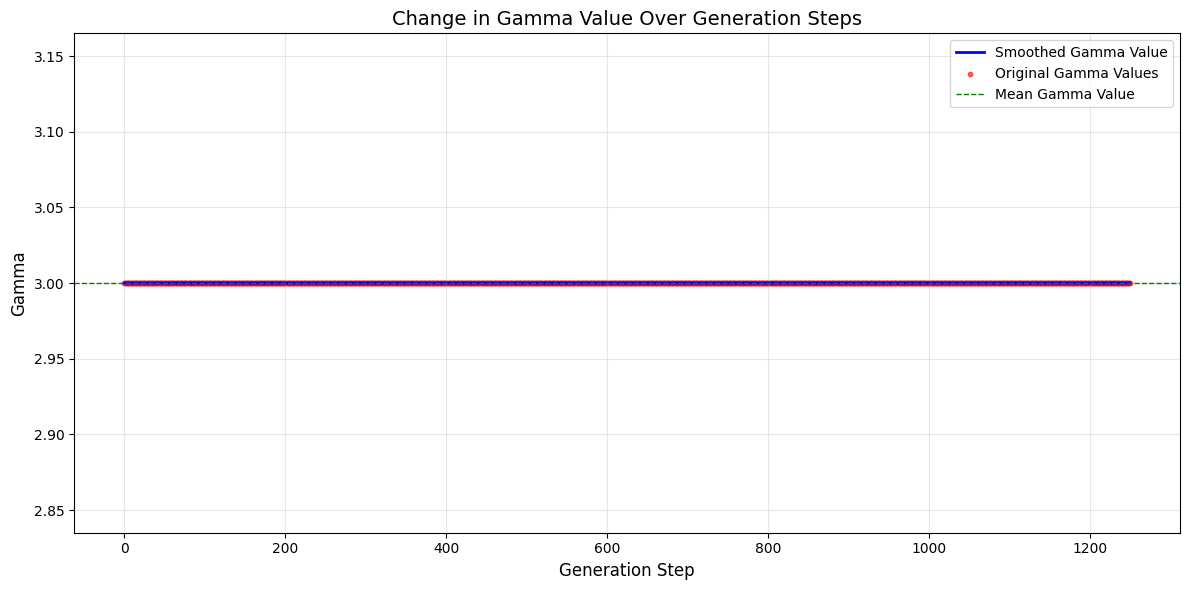

In [17]:
# Run evaluation
results = evaluate_speculative_decoding(test_dataset, model)

### Beam Search

In [ ]:
class SpeculativeDecoder:
    """
    A class implementing speculative decoding for language models.

    This class uses a larger target model and a smaller draft model to perform
    speculative decoding, potentially speeding up text generation.

    Attributes:
        device (str): The device to run the models on ('cuda' or 'cpu').
        target_model (AutoModelForCausalLM): The larger, more accurate language model.
        draft_model (AutoModelForCausalLM): The smaller, faster language model for draft predictions.
        tokenizer (AutoTokenizer): The tokenizer for both models.
    """
    

    def __init__(self, target_model_name, draft_model_name, device='cuda' if torch.cuda.is_available() else 'cpu'):
        """
        Initialize the SpeculativeDecoder with target and draft models.

        Args:
            target_model_name (str): The name or path of the target (larger) model.
            draft_model_name (str): The name or path of the draft (smaller) model.
            device (str): The device to run the models on. Defaults to 'cuda' if available, else 'cpu'.
        """
        
        self.device = device
        self.Mp = AutoModelForCausalLM.from_pretrained(target_model_name).to(self.device)
        self.Mq = AutoModelForCausalLM.from_pretrained(draft_model_name).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(target_model_name)
        self.no_accepted_tokens = 0
        self.alpha = 0 
        
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        self.Mp.eval()
        self.Mq.eval()

    @staticmethod
    def sample(logits, temperature, top_k, top_p):
        
        """
        Adjust logits for sampling based on temperature, top-k, and top-p parameters.

        Args:
            logits (torch.Tensor): The input logits.
            temperature (float): The temperature for sampling.
            top_k (int): The number of top tokens to consider for top-k sampling.
            top_p (float): The cumulative probability threshold for top-p sampling.

        Returns:
            torch.Tensor: The adjusted probability distribution.
        """
        
        if temperature <= 1e-6:
            return F.one_hot(logits.argmax(dim=-1), num_classes=logits.size(-1)).float()
        
        logits = logits / temperature
        
        if top_k > 0:
            top_k = min(top_k, logits.size(-1))
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            logits[indices_to_remove] = float('-inf')
        
        if top_p < 1.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0
            indices_to_remove = sorted_indices_to_remove.scatter(dim=-1, index=sorted_indices, src=sorted_indices_to_remove)
            logits[indices_to_remove] = float('-inf')
        
        return F.softmax(logits, dim=-1)

    def generate_beam_search(
        self, 
        prompt: str, 
        w: int, 
        u: int, 
        gamma: int, 
        max_new_tokens: int = 100
    ) -> List[str]:

        """
        Generate text using speculative beam search.

        Args:
            prompt (str): The input prompt to start generation from.
            w (int): The original beam width for the target model (Mp).
            u (int): The beam width for the approximation model (Mq), where u >= w.
            gamma (int): The number of speculative steps.
            max_new_tokens (int): The maximum number of new tokens to generate. Defaults to 100.

        Returns:
            List[str]: The list of generated sequences.
        """
        stime = time.time()
        input_ids = self.tokenizer.encode(prompt, return_tensors="pt").to(self.device)
        attention_mask = torch.ones_like(input_ids)

        # Initialize beams
        beams = [(input_ids, attention_mask, 0.0)]  # List of tuples: (input_ids, attention_mask, cumulative_log_prob)

        for step in range(max_new_tokens):
            all_candidates = []
            for beam_idx, (beam_input_ids, beam_attention_mask, beam_log_prob) in enumerate(beams):
                with torch.no_grad():
                    outputs = self.Mq.generate(
                        input_ids=beam_input_ids,
                        attention_mask=beam_attention_mask,
                        max_new_tokens=gamma,
                        num_beams=u,
                        do_sample=False,
                        return_dict_in_generate=True,
                        output_scores=True,
                        pad_token_id=self.tokenizer.pad_token_id,
                    )

                # Collect candidates
                for i in range(u):
                    candidate_ids = outputs.sequences[i, beam_input_ids.size(1):]  # New tokens
                    candidate_log_prob = outputs.scores[0][i].item()  # Assuming log probabilities
                    all_candidates.append((candidate_ids, beam_attention_mask, beam_log_prob + candidate_log_prob))

            # Rank all candidates based on cumulative log probability
            all_candidates = sorted(all_candidates, key=lambda x: x[2], reverse=True)
            # Select top w candidates
            beams = all_candidates[:w]

            # Speculative verification with target model (Mp)
            # For each candidate, check if it's within topw (Mp)
            verified_beams = []
            for candidate_ids, candidate_attention_mask, candidate_log_prob in beams:
                # Concatenate prompt with candidate
                full_input_ids = torch.cat([input_ids, candidate_ids.unsqueeze(0)], dim=1)
                full_attention_mask = torch.cat([attention_mask, torch.ones_like(candidate_ids).unsqueeze(0)], dim=1)

                with torch.no_grad():
                    target_outputs = self.Mp(full_input_ids, attention_mask=full_attention_mask, return_dict=True)
                    target_logits = target_outputs.logits[:, -1, :]  # Logits for the last token
                    target_probs = F.softmax(target_logits, dim=-1)
                    topw_probs, topw_indices = torch.topk(target_probs, k=w, dim=-1)

                # Check if candidate is within topw (Mp)
                # Since beam search involves sequences, ensure the last token is in topw
                candidate_token = candidate_ids[-1].unsqueeze(0)
                if candidate_token in topw_indices:
                    verified_beams.append((full_input_ids, full_attention_mask, candidate_log_prob))

            # Update beams with verified candidates
            beams = verified_beams[:w]

            if not beams:
                print("No beams passed the verification step.")
                break

            # Print current beams
            print(f"Step {step + 1}:")
            for beam_input_ids, beam_attention_mask, beam_log_prob in beams:
                generated_text = self.tokenizer.decode(beam_input_ids[0], skip_special_tokens=True)
                print(f"Beam: {generated_text} | Log Prob: {beam_log_prob}")
            print("-------------------------------")

        total_time = time.time() - stime
        print(f"\nTotal time taken for beam search: {total_time:.2f} s")

        # Decode final beams
        generated_sequences = [self.tokenizer.decode(beam_input_ids[0], skip_special_tokens=True) for beam_input_ids, _, _ in beams]
        return generated_sequences


    def generate(self, prompt, temperature=1.0, top_k=0, top_p=1.0, initial_gamma=3, max_new_tokens=50):
            
            """
            Generate text using speculative decoding with a dynamic gamma adjustment.

            Args:
                prompt (str): The input prompt to start generation from.
                temperature (float): The temperature for sampling. Defaults to 1.0.
                top_k (int): The number of top tokens to consider for top-k sampling. Defaults to 0 (disabled).
                top_p (float): The cumulative probability threshold for top-p sampling. Defaults to 1.0 (disabled).
                initial_gamma (int): The initial number of tokens to generate speculatively in each iteration. Defaults to 3.
                max_new_tokens (int): The maximum number of new tokens to generate. Defaults to 50.

            Returns:
                str: The generated text.
            """
            input_ids = self.tokenizer.encode(prompt, return_tensors="pt").to(self.device)
            attention_mask = torch.ones_like(input_ids)

            gamma = initial_gamma  # Start with initial gamma value
            min_gamma, max_gamma = 1, 10  # Define min and max bounds for gamma
            acceptance_threshold_high, acceptance_threshold_low = 0.8, 0.3  # Thresholds for adjusting gamma
            betas = []
            
            for _ in range(0, max_new_tokens, gamma + 1):
                # Draft model generation
                with torch.no_grad():
                    draft_outputs = self.Mq.generate(
                        input_ids,
                        attention_mask=attention_mask,
                        max_new_tokens=gamma,
                        do_sample=True,
                        temperature=temperature,
                        top_k=top_k,
                        top_p=top_p,
                        return_dict_in_generate=True,
                        output_scores=True,
                        pad_token_id=self.tokenizer.pad_token_id,
                    )

                draft_tokens = draft_outputs.sequences[:, input_ids.size(1):]
                draft_probs = torch.stack(draft_outputs.scores).softmax(-1)

                # Target model forward pass
                with torch.no_grad():
                    target_outputs = self.Mp(
                        torch.cat([input_ids, draft_tokens], dim=1),
                        attention_mask=torch.cat([attention_mask, torch.ones_like(draft_tokens)], dim=1),
                        return_dict=True,
                    )

                target_logits = target_outputs.logits[:, input_ids.size(1)-1:-1]
                target_probs = self.sample(target_logits, temperature, top_k, top_p)

                # Speculative sampling and acceptance calculation
                accepted_tokens = []
                num_accepted = 0
                for i in range(min(gamma, draft_tokens.size(1))):
                    draft_token = draft_tokens[:, i]
                    draft_prob = draft_probs[i].gather(-1, draft_token.unsqueeze(-1)).squeeze(-1)
                    target_prob = target_probs[:, i].gather(-1, draft_token.unsqueeze(-1)).squeeze(-1)

                    accept_prob = torch.min(torch.ones_like(target_prob), target_prob / draft_prob)
                    if torch.rand(1, device=self.device) < accept_prob:
                        accepted_tokens.append(draft_token)
                        num_accepted += 1
                    else:
                        break

                # Adjust gamma based on acceptance rate
                acceptance_rate = num_accepted / gamma
                betas.append(acceptance_rate)
                if acceptance_rate > acceptance_threshold_high and gamma < max_gamma:
                    gamma += 1
                elif acceptance_rate < acceptance_threshold_low and gamma > min_gamma:
                    gamma -= 1

                # Append accepted tokens and move to the next input sequence
#                 accepted_tokens.append(draft_tokens[:, num_accepted] if num_accepted < draft_probs.size(1) else next_token)
                if num_accepted < draft_probs.size(1):
                    accepted_tokens.append(draft_tokens[:, num_accepted])
                else:
                    # If num_accepted >= draft_probs.size(1), define next_token here
                    next_token = torch.multinomial(target_probs[:, -1], num_samples=1)
                    accepted_tokens.append(next_token)

                new_tokens = torch.cat([token.view(1, 1) for token in accepted_tokens], dim=1)

                input_ids = torch.cat([input_ids, new_tokens], dim=1)
                attention_mask = torch.cat([attention_mask, torch.ones_like(new_tokens)], dim=1)

                if input_ids.size(1) - len(self.tokenizer.encode(prompt)) >= max_new_tokens:
                    break
            self.alpha = sum(betas) / len(betas) 

            return self.tokenizer.decode(input_ids[0], skip_special_tokens=True)


    def target_generate_greedy(self, prompt, max_new_tokens=50):
        """
        Generate text using standard greedy decoding with the target model.

        Args:
            prompt (str): The input prompt to start generation from.
            max_new_tokens (int): The maximum number of new tokens to generate. Defaults to 50.

        Returns:
            str: The generated text.
        """
        model_inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        greedy_output = self.target_model.generate(**model_inputs, max_new_tokens=max_new_tokens)
        return self.tokenizer.decode(greedy_output[0])

    def draft_generate_greedy(self, prompt, max_new_tokens=50):
        """
        Generate text using standard greedy decoding with the draft model.

        Args:
            prompt (str): The input prompt to start generation from.
            max_new_tokens (int): The maximum number of new tokens to generate. Defaults to 50

        Returns:
            str: The generated text.
        """
    
        model_inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        greedy_output = self.draft_model.generate(**model_inputs, max_new_tokens=max_new_tokens)
        return self.tokenizer.decode(greedy_output[0])